АНАЛИЗ ФАЙЛА И СРАВНЕНИЕ СЕНСОРОВ
Файл загружен: C:\Users\VKosinov\Desktop\GitHub\work\acceleration_error\final.csv
Количество строк: 115
Количество столбцов: 10

Столбцы в файле:
  - acceleration
  - frequency
  - boost
  - sensor
  - source_file
  - axis
  - Optimal_k
  - error_%
  - new_error_%
  - source_filename

Уникальные сенсоры: [np.int64(1), np.int64(2)]
Уникальные оси: ['X', 'Y', 'Z']

Сравниваем сенсоры: 1 и 2
Ошибка при преобразовании столбца boost: could not convert string to float: '05.июн'

ОБЩАЯ СТАТИСТИКА ПО СЕНСОРАМ

Сенсор 1:
  Количество записей: 57
  Оси: ['X', 'Y', 'Z']

  Старые ошибки:
    Максимальная: 6.6600%
    Средняя: 1.5784%
    Медиана: 0.8800%
    ≤1.5%: 35/57 (61.4%)

  Новые ошибки:
    Максимальная: 1.3253%
    Средняя: 0.1333%
    Медиана: 0.0503%
    ≤1.5%: 57/57 (100.0%)

  Улучшение:
    Макс. ошибка: 5.3347%
    Сред. ошибка: 1.4451%
    Строк ≤1.5%: +22

Сенсор 2:
  Количество записей: 58
  Оси: ['X', 'Y', 'Z']

  Старые ошибки:
    Максимальн

C:\Users\VKosinov\AppData\Local\Temp\ipykernel_7984\1238500810.py:194: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(boxplot_data, labels=boxplot_labels, patch_artist=True)


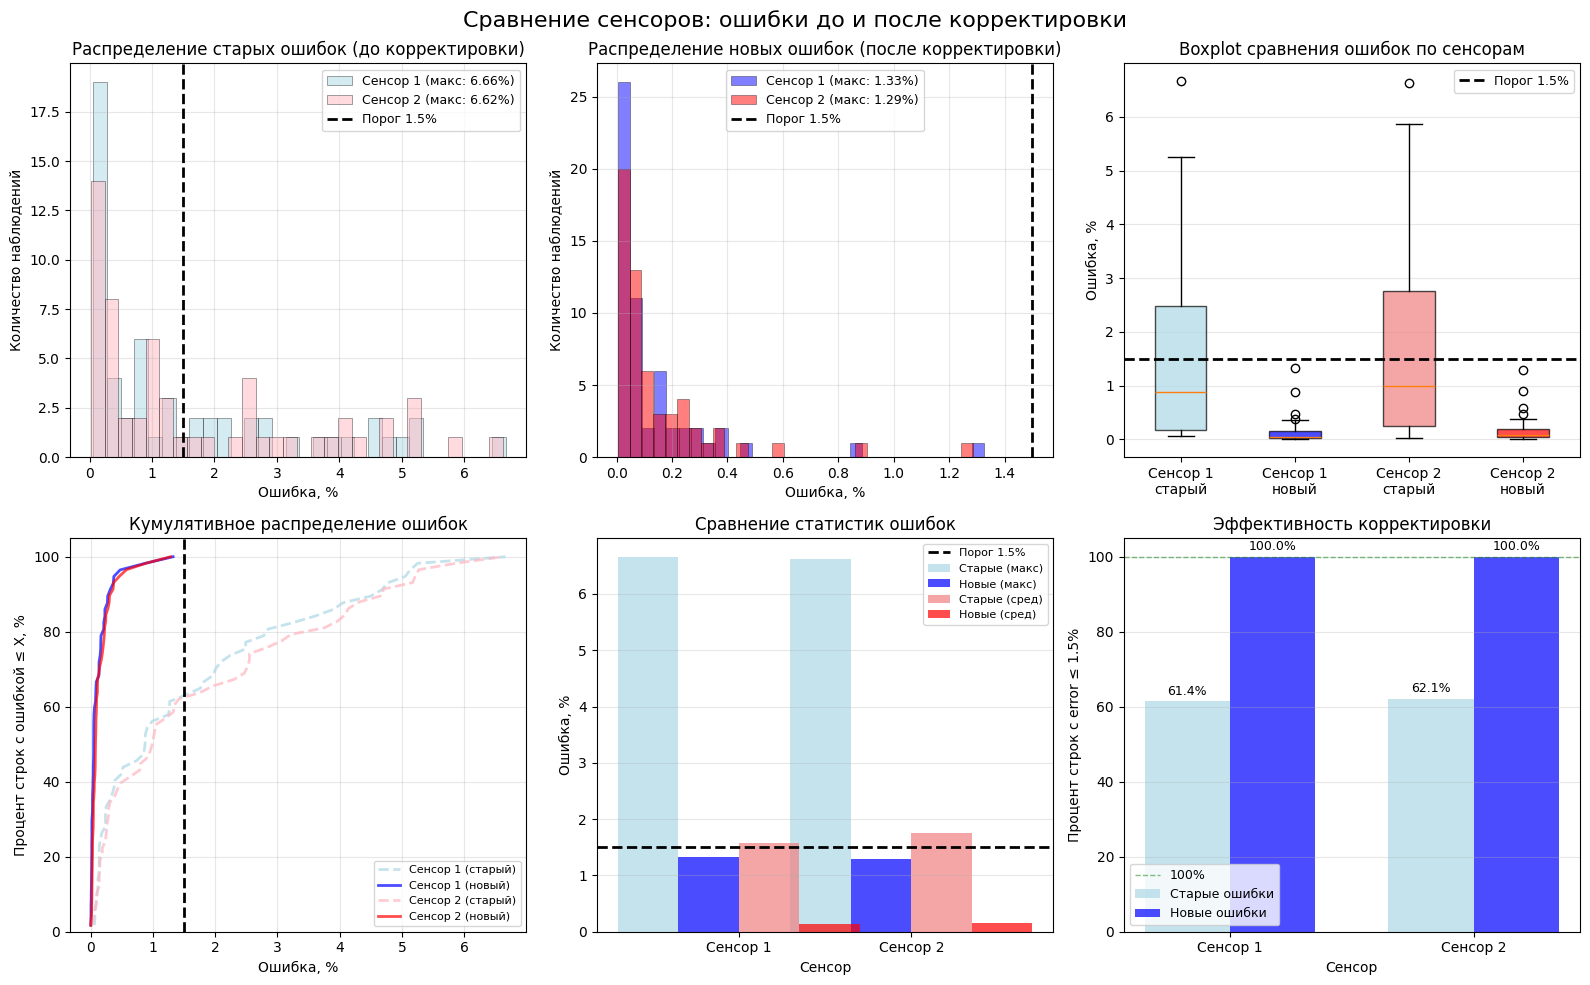


АНАЛИЗ ПО ОСЯМ

Ось X:
  Сенсор 1: 20 старых записей, 20 новых записей
  Сенсор 2: 20 старых записей, 20 новых записей

Ось Y:
  Сенсор 1: 20 старых записей, 20 новых записей
  Сенсор 2: 20 старых записей, 20 новых записей

Ось Z:
  Сенсор 1: 17 старых записей, 17 новых записей
  Сенсор 2: 18 старых записей, 18 новых записей


C:\Users\VKosinov\AppData\Local\Temp\ipykernel_7984\1238500810.py:372: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp_axis = ax.boxplot(boxplot_data_axis, labels=boxplot_labels_axis, patch_artist=True)
C:\Users\VKosinov\AppData\Local\Temp\ipykernel_7984\1238500810.py:372: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp_axis = ax.boxplot(boxplot_data_axis, labels=boxplot_labels_axis, patch_artist=True)
C:\Users\VKosinov\AppData\Local\Temp\ipykernel_7984\1238500810.py:372: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp_axis = ax.boxplot(boxplot_data_axis, labels=boxplot_labels_axis, patch_artist=True)


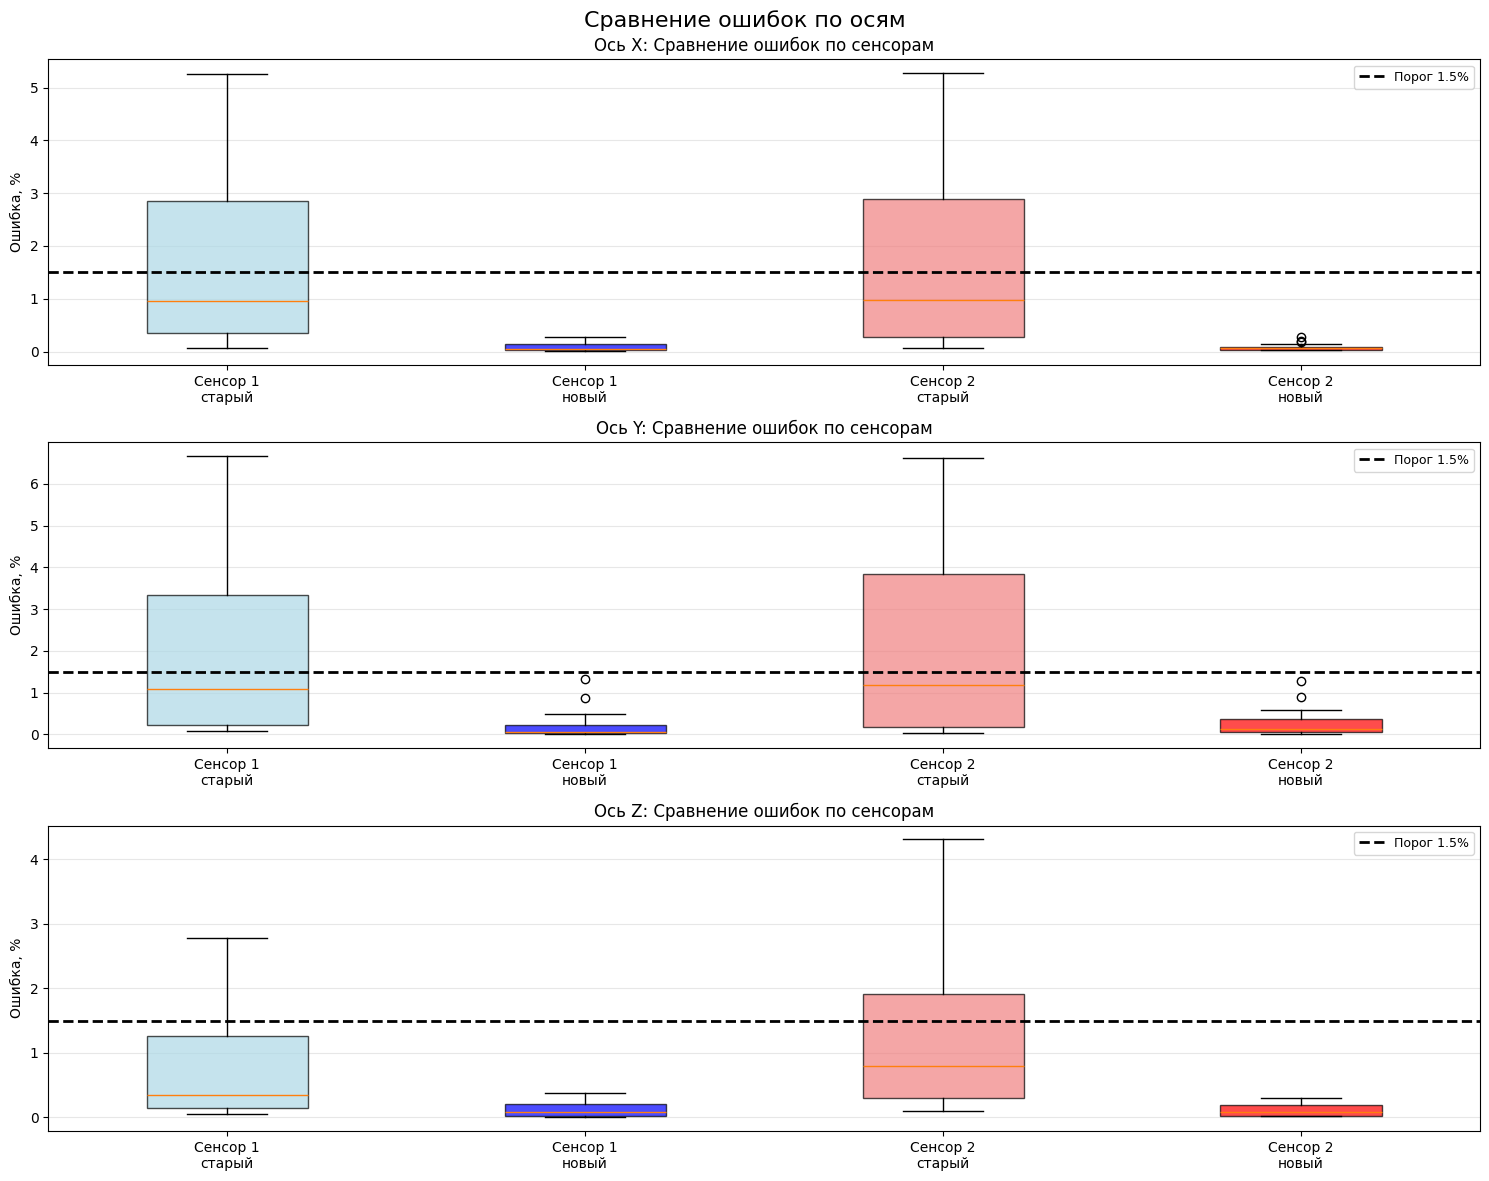


ИТОГИ СРАВНЕНИЯ СЕНСОРОВ

Сравнение сенсора 1 и сенсора 2:

Старые ошибки (до корректировки):
  Макс. ошибка: 6.660% vs 6.620%
  Сред. ошибка: 1.578% vs 1.745%
  ≤1.5%: 61.4% vs 62.1%

Новые ошибки (после корректировки):
  Макс. ошибка: 1.325% vs 1.286%
  Сред. ошибка: 0.133% vs 0.155%
  ≤1.5%: 100.0% vs 100.0%

Улучшение после корректировки:
  Улучшение макс. ошибки: 5.335% vs 5.334%
  Улучшение сред. ошибки: 1.445% vs 1.589%
  Улучшение % строк ≤1.5%: +38.6% vs +37.9%

Оценка эффективности корректировки:
  По максимальному улучшению лучше сенсор 1
  По среднему улучшению лучше сенсор 2
  По итоговой максимальной ошибке лучше сенсор 2

АНАЛИЗ ЗАВЕРШЕН


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ========== АНАЛИЗ ФАЙЛА И СРАВНЕНИЕ СЕНСОРОВ ==========

# Путь к общему финальному файлу
final_all_path = r'C:\Users\VKosinov\Desktop\GitHub\work\acceleration_error\final.csv'

print(f"{'='*80}")
print("АНАЛИЗ ФАЙЛА И СРАВНЕНИЕ СЕНСОРОВ")
print(f"{'='*80}")

try:
    # Загружаем данные из файла
    df = pd.read_csv(final_all_path, delimiter=';', encoding='cp1251')
    print(f"Файл загружен: {final_all_path}")
    print(f"Количество строк: {len(df)}")
    print(f"Количество столбцов: {len(df.columns)}")
    print(f"\nСтолбцы в файле:")
    for col in df.columns:
        print(f"  - {col}")
    
    # Проверяем наличие необходимых столбцов
    required_columns = ['sensor', 'axis', 'error_%', 'new_error_%', 'frequency', 'boost']
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        print(f"\nВНИМАНИЕ: Отсутствуют необходимые столбцы: {missing_columns}")
        print("Анализ может быть неполным.")
    
    # Определяем уникальные сенсоры
    sensors = sorted(df['sensor'].unique())
    print(f"\nУникальные сенсоры: {sensors}")
    
    # Определяем уникальные оси
    axes = sorted(df['axis'].unique())
    print(f"Уникальные оси: {axes}")
    
    # Проверяем наличие данных для двух сенсоров
    if len(sensors) < 2:
        print("\nВНИМАНИЕ: В файле меньше 2 сенсоров. Сравнение невозможно.")
    else:
        print(f"\nСравниваем сенсоры: {sensors[0]} и {sensors[1]}")
        
        # Функция для преобразования чисел с запятой в float
        def convert_to_float(value):
            if isinstance(value, str):
                return float(value.replace(',', '.'))
            return float(value)
        
        # Преобразуем числовые столбцы
        numeric_columns = ['error_%', 'new_error_%', 'frequency', 'boost']
        for col in numeric_columns:
            if col in df.columns:
                try:
                    df[f'{col}_num'] = df[col].apply(convert_to_float)
                except Exception as e:
                    print(f"Ошибка при преобразовании столбца {col}: {e}")
                    df[f'{col}_num'] = np.nan
        
        # ========== ОБЩИЙ АНАЛИЗ ПО СЕНСОРАМ ==========
        print(f"\n{'='*80}")
        print("ОБЩАЯ СТАТИСТИКА ПО СЕНСОРАМ")
        print(f"{'='*80}")
        
        # Создаем отдельные DataFrame для каждого сенсора
        sensor_dfs = {}
        stats_summary = {}
        
        for sensor in sensors:
            sensor_df = df[df['sensor'] == sensor].copy()
            sensor_dfs[sensor] = sensor_df
            
            # Статистика для старой ошибки
            old_errors = sensor_df['error_%_num'].dropna()
            new_errors = sensor_df['new_error_%_num'].dropna()
            
            stats = {
                'old_max': old_errors.max() if len(old_errors) > 0 else np.nan,
                'old_mean': old_errors.mean() if len(old_errors) > 0 else np.nan,
                'old_median': old_errors.median() if len(old_errors) > 0 else np.nan,
                'old_below_1.5': (old_errors <= 1.5).sum() if len(old_errors) > 0 else 0,
                'old_total': len(old_errors),
                'new_max': new_errors.max() if len(new_errors) > 0 else np.nan,
                'new_mean': new_errors.mean() if len(new_errors) > 0 else np.nan,
                'new_median': new_errors.median() if len(new_errors) > 0 else np.nan,
                'new_below_1.5': (new_errors <= 1.5).sum() if len(new_errors) > 0 else 0,
                'new_total': len(new_errors),
            }
            
            stats_summary[sensor] = stats
            
            print(f"\nСенсор {sensor}:")
            print(f"  Количество записей: {len(sensor_df)}")
            print(f"  Оси: {sorted(sensor_df['axis'].unique())}")
            
            if len(old_errors) > 0:
                print(f"\n  Старые ошибки:")
                print(f"    Максимальная: {stats['old_max']:.4f}%")
                print(f"    Средняя: {stats['old_mean']:.4f}%")
                print(f"    Медиана: {stats['old_median']:.4f}%")
                print(f"    ≤1.5%: {stats['old_below_1.5']}/{stats['old_total']} ({stats['old_below_1.5']/stats['old_total']*100:.1f}%)")
            
            if len(new_errors) > 0:
                print(f"\n  Новые ошибки:")
                print(f"    Максимальная: {stats['new_max']:.4f}%")
                print(f"    Средняя: {stats['new_mean']:.4f}%")
                print(f"    Медиана: {stats['new_median']:.4f}%")
                print(f"    ≤1.5%: {stats['new_below_1.5']}/{stats['new_total']} ({stats['new_below_1.5']/stats['new_total']*100:.1f}%)")
            
            if len(old_errors) > 0 and len(new_errors) > 0:
                improvement_max = stats['old_max'] - stats['new_max']
                improvement_mean = stats['old_mean'] - stats['new_mean']
                improvement_count = stats['new_below_1.5'] - stats['old_below_1.5']
                
                print(f"\n  Улучшение:")
                print(f"    Макс. ошибка: {improvement_max:.4f}%")
                print(f"    Сред. ошибка: {improvement_mean:.4f}%")
                print(f"    Строк ≤1.5%: +{improvement_count}")
        
        # ========== ГРАФИКИ СРАВНЕНИЯ СЕНСОРОВ ==========
        
       # 1. Сравнение распределений ошибок до и после для обоих сенсоров
        fig1 = plt.figure(figsize=(16, 10))

        # Создаем цветовую схему для сенсоров и типов ошибок
        # Для сенсора 1: синие оттенки, для сенсора 2: красные оттенки
        # Старые ошибки: более светлые оттенки, новые ошибки: более темные оттенки
        colors = {
            '1_old': '#ADD8E6',  # Светло-синий для сенсор 1 старые ошибки
            '1_new': '#0000FF',  # Синий для сенсор 1 новые ошибки
            '2_old': '#FFB6C1',  # Светло-красный для сенсор 2 старые ошибки
            '2_new': '#FF0000'   # Красный для сенсор 2 новые ошибки
        }

        sensor_labels = {sensor: f"Сенсор {sensor}" for sensor in sensors}

        # 1.1 Гистограммы старых ошибок для обоих сенсоров
        ax1 = plt.subplot(2, 3, 1)
        for sensor in sensors:
            if sensor in sensor_dfs:
                old_errors = sensor_dfs[sensor]['error_%_num'].dropna()
                if len(old_errors) > 0:
                    color_key = f'{sensor}_old'
                    ax1.hist(old_errors, bins=30, alpha=0.5, color=colors.get(color_key, 'gray'),
                            label=f'{sensor_labels[sensor]} (макс: {stats_summary[sensor]["old_max"]:.2f}%)',
                            edgecolor='black', linewidth=0.5)

        ax1.axvline(x=1.5, color='black', linestyle='--', linewidth=2, label='Порог 1.5%')
        ax1.set_xlabel('Ошибка, %')
        ax1.set_ylabel('Количество наблюдений')
        ax1.set_title('Распределение старых ошибок (до корректировки)')
        ax1.legend(fontsize=9)
        ax1.grid(True, alpha=0.3)

        # 1.2 Гистограммы новых ошибок для обоих сенсоров
        ax2 = plt.subplot(2, 3, 2)
        for sensor in sensors:
            if sensor in sensor_dfs:
                new_errors = sensor_dfs[sensor]['new_error_%_num'].dropna()
                if len(new_errors) > 0:
                    color_key = f'{sensor}_new'
                    ax2.hist(new_errors, bins=30, alpha=0.5, color=colors.get(color_key, 'gray'),
                            label=f'{sensor_labels[sensor]} (макс: {stats_summary[sensor]["new_max"]:.2f}%)',
                            edgecolor='black', linewidth=0.5)

        ax2.axvline(x=1.5, color='black', linestyle='--', linewidth=2, label='Порог 1.5%')
        ax2.set_xlabel('Ошибка, %')
        ax2.set_ylabel('Количество наблюдений')
        ax2.set_title('Распределение новых ошибок (после корректировки)')
        ax2.legend(fontsize=9)
        ax2.grid(True, alpha=0.3)
        
        # 1.3 Boxplot сравнения старых и новых ошибок по сенсорам
        ax3 = plt.subplot(2, 3, 3)
        boxplot_data = []
        boxplot_labels = []
        
        for sensor in sensors:
            if sensor in sensor_dfs:
                old_errors = sensor_dfs[sensor]['error_%_num'].dropna()
                new_errors = sensor_dfs[sensor]['new_error_%_num'].dropna()
                
                if len(old_errors) > 0:
                    boxplot_data.append(old_errors.values)
                    boxplot_labels.append(f'Сенсор {sensor}\nстарый')
                
                if len(new_errors) > 0:
                    boxplot_data.append(new_errors.values)
                    boxplot_labels.append(f'Сенсор {sensor}\nновый')
        
        bp = ax3.boxplot(boxplot_data, labels=boxplot_labels, patch_artist=True)
        
        # Раскрашиваем boxplot
        colors_box = []
        for label in boxplot_labels:
            if 'старый' in label:
                colors_box.append('lightblue' if '1' in label else 'lightcoral')
            else:
                colors_box.append('blue' if '1' in label else 'red')
        
        for patch, color in zip(bp['boxes'], colors_box):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax3.axhline(y=1.5, color='black', linestyle='--', linewidth=2, label='Порог 1.5%')
        ax3.set_ylabel('Ошибка, %')
        ax3.set_title('Boxplot сравнения ошибок по сенсорам')
        ax3.legend(fontsize=9)
        ax3.grid(True, alpha=0.3, axis='y')
        
        # 1.4 Кумулятивное распределение для сравнения
        
        ax4 = plt.subplot(2, 3, 4)

        
        colors = {
            '1_old': '#ADD8E6',  # Светло-синий для сенсор 1 старые ошибки
            '1_new': '#0000FF',  # Синий для сенсор 1 новые ошибки
            '2_old': '#FFB6C1',  # Светло-красный для сенсор 2 старые ошибки
            '2_new': '#FF0000'   # Красный для сенсор 2 новые ошибки
        }

        for sensor in sensors:
            if sensor in sensor_dfs:
                # Старые ошибки
                old_errors = sensor_dfs[sensor]['error_%_num'].dropna()
                if len(old_errors) > 0:
                    sorted_old = np.sort(old_errors.values)
                    cumulative_old = np.arange(1, len(sorted_old) + 1) / len(sorted_old) * 100
                    color_key = f'{sensor}_old'
                    ax4.plot(sorted_old, cumulative_old, color=colors.get(color_key, 'gray'), 
                     linestyle='--', linewidth=2, alpha=0.7, label=f'Сенсор {sensor} (старый)')
        
                # Новые ошибки
                new_errors = sensor_dfs[sensor]['new_error_%_num'].dropna()
                if len(new_errors) > 0:
                    sorted_new = np.sort(new_errors.values)
                    cumulative_new = np.arange(1, len(sorted_new) + 1) / len(sorted_new) * 100
                    color_key = f'{sensor}_new'
                    ax4.plot(sorted_new, cumulative_new, color=colors.get(color_key, 'gray'), 
                            linewidth=2, alpha=0.7, label=f'Сенсор {sensor} (новый)')

        ax4.axvline(x=1.5, color='black', linestyle='--', linewidth=2)
        ax4.set_xlabel('Ошибка, %')
        ax4.set_ylabel('Процент строк с ошибкой ≤ X, %')
        ax4.set_title('Кумулятивное распределение ошибок')
        ax4.legend(fontsize=8, loc='lower right')
        ax4.grid(True, alpha=0.3)
        ax4.set_ylim([0, 105])
        
        # 1.5 Сравнение максимальных и средних ошибок
        ax5 = plt.subplot(2, 3, 5)
        
        metrics = ['Макс. ошибка', 'Сред. ошибка', 'Медиана ошибки']
        sensor_positions = np.arange(len(sensors))
        width = 0.35
        
        old_values_max = [stats_summary[sensor]['old_max'] for sensor in sensors]
        new_values_max = [stats_summary[sensor]['new_max'] for sensor in sensors]
        
        old_values_mean = [stats_summary[sensor]['old_mean'] for sensor in sensors]
        new_values_mean = [stats_summary[sensor]['new_mean'] for sensor in sensors]
        
        old_values_median = [stats_summary[sensor]['old_median'] for sensor in sensors]
        new_values_median = [stats_summary[sensor]['new_median'] for sensor in sensors]
        
        # Максимальные ошибки
        bars1 = ax5.bar(sensor_positions - width, old_values_max, width, 
                       label='Старые (макс)', color='lightblue', alpha=0.7)
        bars2 = ax5.bar(sensor_positions, new_values_max, width, 
                       label='Новые (макс)', color='blue', alpha=0.7)
        
        # Средние ошибки
        bars3 = ax5.bar(sensor_positions + width, old_values_mean, width, 
                       label='Старые (сред)', color='lightcoral', alpha=0.7)
        bars4 = ax5.bar(sensor_positions + 2*width, new_values_mean, width, 
                       label='Новые (сред)', color='red', alpha=0.7)
        
        ax5.axhline(y=1.5, color='black', linestyle='--', linewidth=2, label='Порог 1.5%')
        ax5.set_xlabel('Сенсор')
        ax5.set_ylabel('Ошибка, %')
        ax5.set_title('Сравнение статистик ошибок')
        ax5.set_xticks(sensor_positions + width/2)
        ax5.set_xticklabels([f'Сенсор {sensor}' for sensor in sensors])
        ax5.legend(fontsize=8)
        ax5.grid(True, alpha=0.3, axis='y')
        
        # 1.6 Процент строк с ошибкой ≤ 1.5%
        ax6 = plt.subplot(2, 3, 6)
        
        old_percent = []
        new_percent = []
        
        for sensor in sensors:
            stats = stats_summary[sensor]
            if stats['old_total'] > 0:
                old_percent.append(stats['old_below_1.5'] / stats['old_total'] * 100)
            else:
                old_percent.append(0)
            
            if stats['new_total'] > 0:
                new_percent.append(stats['new_below_1.5'] / stats['new_total'] * 100)
            else:
                new_percent.append(0)
        
        x_pos = np.arange(len(sensors))
        
        bars_old = ax6.bar(x_pos - width/2, old_percent, width, 
                          label='Старые ошибки', color='lightblue', alpha=0.7)
        bars_new = ax6.bar(x_pos + width/2, new_percent, width, 
                          label='Новые ошибки', color='blue', alpha=0.7)
        
        ax6.axhline(y=100, color='green', linestyle='--', linewidth=1, alpha=0.5, label='100%')
        ax6.set_xlabel('Сенсор')
        ax6.set_ylabel('Процент строк с error ≤ 1.5%')
        ax6.set_title('Эффективность корректировки')
        ax6.set_xticks(x_pos)
        ax6.set_xticklabels([f'Сенсор {sensor}' for sensor in sensors])
        ax6.set_ylim([0, 105])
        ax6.legend(fontsize=9)
        ax6.grid(True, alpha=0.3, axis='y')
        
        # Добавляем значения на столбцы
        for bar, value in zip(bars_old, old_percent):
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{value:.1f}%', ha='center', va='bottom', fontsize=9)
        
        for bar, value in zip(bars_new, new_percent):
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{value:.1f}%', ha='center', va='bottom', fontsize=9)
        
        plt.suptitle('Сравнение сенсоров: ошибки до и после корректировки', fontsize=16, y=0.98)
        plt.tight_layout()
        plt.show()
        
        # ========== АНАЛИЗ ПО ОСЯМ ==========
        print(f"\n{'='*80}")
        print("АНАЛИЗ ПО ОСЯМ")
        print(f"{'='*80}")
        
        fig2 = plt.figure(figsize=(15, 12))
        
        for idx, axis in enumerate(axes, 1):
            ax = plt.subplot(len(axes), 1, idx)
            
            axis_data = df[df['axis'] == axis].copy()
            
            # Собираем данные для boxplot
            boxplot_data_axis = []
            boxplot_labels_axis = []
            
            for sensor in sensors:
                sensor_axis_data = axis_data[axis_data['sensor'] == sensor]
                
                old_errors = sensor_axis_data['error_%_num'].dropna()
                new_errors = sensor_axis_data['new_error_%_num'].dropna()
                
                if len(old_errors) > 0:
                    boxplot_data_axis.append(old_errors.values)
                    boxplot_labels_axis.append(f'Сенсор {sensor}\nстарый')
                
                if len(new_errors) > 0:
                    boxplot_data_axis.append(new_errors.values)
                    boxplot_labels_axis.append(f'Сенсор {sensor}\nновый')
            
            if boxplot_data_axis:
                bp_axis = ax.boxplot(boxplot_data_axis, labels=boxplot_labels_axis, patch_artist=True)
                
                # Раскрашиваем boxplot для оси
                colors_axis = []
                for label in boxplot_labels_axis:
                    if 'старый' in label:
                        colors_axis.append('lightblue' if '1' in label else 'lightcoral')
                    else:
                        colors_axis.append('blue' if '1' in label else 'red')
                
                for patch, color in zip(bp_axis['boxes'], colors_axis):
                    patch.set_facecolor(color)
                    patch.set_alpha(0.7)
                
                ax.axhline(y=1.5, color='black', linestyle='--', linewidth=2, label='Порог 1.5%')
                ax.set_ylabel('Ошибка, %')
                ax.set_title(f'Ось {axis}: Сравнение ошибок по сенсорам')
                ax.legend(fontsize=9)
                ax.grid(True, alpha=0.3, axis='y')
                
                # Вывод статистики для оси
                print(f"\nОсь {axis}:")
                for sensor in sensors:
                    sensor_axis_data = axis_data[axis_data['sensor'] == sensor]
                    old_count = sensor_axis_data['error_%_num'].notna().sum()
                    new_count = sensor_axis_data['new_error_%_num'].notna().sum()
                    print(f"  Сенсор {sensor}: {old_count} старых записей, {new_count} новых записей")
            else:
                ax.text(0.5, 0.5, f'Нет данных для оси {axis}', 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'Ось {axis}: Нет данных')
        
        plt.suptitle('Сравнение ошибок по осям', fontsize=16, y=0.98)
        plt.tight_layout()
        plt.show()
        
        
        # ========== ВЫВОД ИТОГОВ ==========
        print(f"\n{'='*80}")
        print("ИТОГИ СРАВНЕНИЯ СЕНСОРОВ")
        print(f"{'='*80}")
        
        # Сравниваем сенсоры
        if len(sensors) >= 2:
            sensor1, sensor2 = sensors[0], sensors[1]
            
            if sensor1 in stats_summary and sensor2 in stats_summary:
                stats1 = stats_summary[sensor1]
                stats2 = stats_summary[sensor2]
                
                print(f"\nСравнение сенсора {sensor1} и сенсора {sensor2}:")
                
                # Сравнение старых ошибок
                print(f"\nСтарые ошибки (до корректировки):")
                print(f"  Макс. ошибка: {stats1['old_max']:.3f}% vs {stats2['old_max']:.3f}%")
                print(f"  Сред. ошибка: {stats1['old_mean']:.3f}% vs {stats2['old_mean']:.3f}%")
                
                if stats1['old_total'] > 0 and stats2['old_total'] > 0:
                    old_percent1 = stats1['old_below_1.5'] / stats1['old_total'] * 100
                    old_percent2 = stats2['old_below_1.5'] / stats2['old_total'] * 100
                    print(f"  ≤1.5%: {old_percent1:.1f}% vs {old_percent2:.1f}%")
                
                # Сравнение новых ошибок
                print(f"\nНовые ошибки (после корректировки):")
                print(f"  Макс. ошибка: {stats1['new_max']:.3f}% vs {stats2['new_max']:.3f}%")
                print(f"  Сред. ошибка: {stats1['new_mean']:.3f}% vs {stats2['new_mean']:.3f}%")
                
                if stats1['new_total'] > 0 and stats2['new_total'] > 0:
                    new_percent1 = stats1['new_below_1.5'] / stats1['new_total'] * 100
                    new_percent2 = stats2['new_below_1.5'] / stats2['new_total'] * 100
                    print(f"  ≤1.5%: {new_percent1:.1f}% vs {new_percent2:.1f}%")
                
                # Сравнение улучшений
                print(f"\nУлучшение после корректировки:")
                
                improvement_max1 = stats1['old_max'] - stats1['new_max']
                improvement_max2 = stats2['old_max'] - stats2['new_max']
                print(f"  Улучшение макс. ошибки: {improvement_max1:.3f}% vs {improvement_max2:.3f}%")
                
                improvement_mean1 = stats1['old_mean'] - stats1['new_mean']
                improvement_mean2 = stats2['old_mean'] - stats2['new_mean']
                print(f"  Улучшение сред. ошибки: {improvement_mean1:.3f}% vs {improvement_mean2:.3f}%")
                
                if stats1['old_total'] > 0 and stats2['old_total'] > 0:
                    improvement_percent1 = new_percent1 - old_percent1
                    improvement_percent2 = new_percent2 - old_percent2
                    print(f"  Улучшение % строк ≤1.5%: {improvement_percent1:+.1f}% vs {improvement_percent2:+.1f}%")
                
                # Определяем лучший сенсор
                print(f"\nОценка эффективности корректировки:")
                
                # По максимальному улучшению
                if improvement_max1 > improvement_max2:
                    print(f"  По максимальному улучшению лучше сенсор {sensor1}")
                elif improvement_max2 > improvement_max1:
                    print(f"  По максимальному улучшению лучше сенсор {sensor2}")
                else:
                    print(f"  По максимальному улучшению сенсоры равны")
                
                # По среднему улучшению
                if improvement_mean1 > improvement_mean2:
                    print(f"  По среднему улучшению лучше сенсор {sensor1}")
                elif improvement_mean2 > improvement_mean1:
                    print(f"  По среднему улучшению лучше сенсор {sensor2}")
                else:
                    print(f"  По среднему улучшению сенсоры равны")
                
                # По итоговой точности
                if stats1['new_max'] < stats2['new_max']:
                    print(f"  По итоговой максимальной ошибке лучше сенсор {sensor1}")
                elif stats2['new_max'] < stats1['new_max']:
                    print(f"  По итоговой максимальной ошибке лучше сенсор {sensor2}")
                else:
                    print(f"  По итоговой максимальной ошибке сенсоры равны")
        
        print(f"\n{'='*80}")
        print("АНАЛИЗ ЗАВЕРШЕН")
        print(f"{'='*80}")
        
except FileNotFoundError:
    print(f"ОШИБКА: Файл не найден: {final_all_path}")
except Exception as e:
    print(f"ОШИБКА при анализе файла: {e}")
    import traceback
    traceback.print_exc()